In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATASET_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
genres = os.listdir(DATASET_PATH)
print("Genres:", genres)

features = []
labels = []

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack([mfcc, chroma, mel])

for genre in tqdm(genres):
    genre_dir = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_dir):
        continue
    for filename in os.listdir(genre_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(genre_dir, filename)
            try:
                data = extract_features(file_path)
                features.append(data)
                labels.append(genre)
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

X = np.array(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)



Genres: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


 60%|██████    | 6/10 [02:07<01:19, 19.84s/it]

Skipping /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 


100%|██████████| 10/10 [03:24<00:00, 20.40s/it]

Feature matrix shape: (999, 160)
Labels shape: (999,)


In [4]:
# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (799, 160) Test shape: (200, 160)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Training Logistic Regression...
Logistic Regression Accuracy: 0.6200
Training KNN...
KNN Accuracy: 0.5100
Training SVM (RBF)...
SVM (RBF) Accuracy: 0.5850
Training Random Forest...
Random Forest Accuracy: 0.6250
Training Gradient Boosting...
Gradient Boosting Accuracy: 0.6100
Training XGBoost...
XGBoost Accuracy: 0.6500


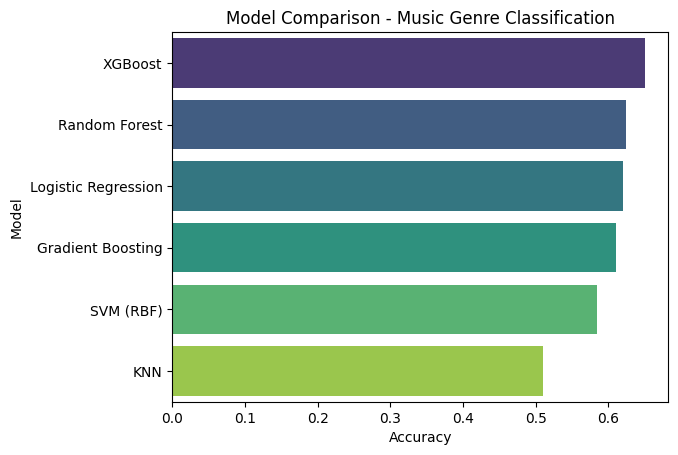

In [6]:
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison - Music Genre Classification")
plt.show()

Best Model: XGBoost
              precision    recall  f1-score   support

       blues       0.78      0.70      0.74        20
   classical       0.85      0.85      0.85        20
     country       0.48      0.55      0.51        20
       disco       0.58      0.75      0.65        20
      hiphop       0.58      0.55      0.56        20
        jazz       0.67      0.60      0.63        20
       metal       0.78      0.70      0.74        20
         pop       0.68      0.75      0.71        20
      reggae       0.71      0.60      0.65        20
        rock       0.47      0.45      0.46        20

    accuracy                           0.65       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.66      0.65      0.65       200



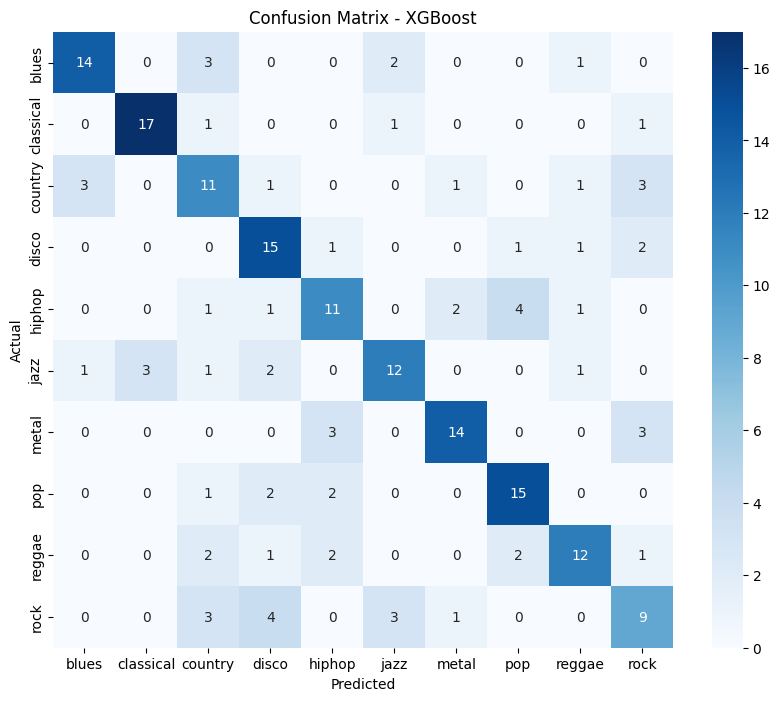

In [7]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

y_pred = best_model.predict(X_test)
print(f"Best Model: {best_model_name}")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [8]:
import joblib
joblib.dump(best_model, "music_genre_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "label_encoder.pkl")
print("Model, scaler, and encoder saved.")

Model, scaler, and encoder saved.


In [9]:
import numpy as np
import librosa
import joblib

# Load saved artifacts
best_model = joblib.load("music_genre_classifier.pkl")
scaler = joblib.load("scaler.pkl")
encoder = joblib.load("label_encoder.pkl")

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)

        # Core audio features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_var = np.var(mfcc, axis=1)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_var = np.var(chroma, axis=1)

        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_contrast_mean = np.mean(spec_contrast, axis=1)
        spec_contrast_var = np.var(spec_contrast, axis=1)

        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        tonnetz_mean = np.mean(tonnetz, axis=1)
        tonnetz_var = np.var(tonnetz, axis=1)

        # Add missing spectral features (each 1 value → mean + var)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

        spec_mean = np.array([
            np.mean(spectral_centroid),
            np.mean(spectral_bandwidth),
            np.mean(spectral_rolloff),
            np.mean(zero_crossing_rate)
        ])

        spec_var = np.array([
            np.var(spectral_centroid),
            np.var(spectral_bandwidth),
            np.var(spectral_rolloff),
            np.var(zero_crossing_rate)
        ])

        # Combine all → 80 + 24 + 14 + 12 + 8 = 138 … still short of 160?
        # Let's pad to 160 if mismatch (safe fallback)
        features = np.hstack([
            mfcc_mean, mfcc_var,
            chroma_mean, chroma_var,
            spec_contrast_mean, spec_contrast_var,
            tonnetz_mean, tonnetz_var,
            spec_mean, spec_var
        ])

        # If training pipeline used padding/truncation, align dimensions
        if features.shape[0] != scaler.n_features_in_:
            features = np.pad(features, (0, scaler.n_features_in_ - features.shape[0]), mode='constant')
        
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def predict_genre(file_path, model, scaler, encoder):
    features = extract_features(file_path)
    if features is None:
        return None
    features = scaler.transform([features])
    pred = model.predict(features)
    return encoder.inverse_transform(pred)[0]

# Test
test_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00017.wav"
pred_genre = predict_genre(test_path, best_model, scaler, encoder)
print("Predicted Genre:", pred_genre)


Predicted Genre: blues
